## Лабораторная работа №2

**Цель** —разработать и обучить сверточную нейронную сеть для задачи классификации изображений на наборе данных [Cifar-10](https://www.cs.toronto.edu/~kriz/cifar.html) с использованием  PyTorch. 

### Требования к результатам выполнения работы

1. Требования к структуре и содержимому Jupyter Notebook:
    - Загрузить и проверить данные (необходимо обеспечить демонстрацию избранных изображений и меток классов для подтверждения корректности загрузки и совпадения размерностей).
    - Реализовать архитектуру нейронной сеть с использованием фреймворка PyTorch.
    - Настроить гиперпараметры обучения (например, архитектуры, скорости обучения и размера пачки (batch size)).
    - Вывести ошибку классификации и точность на тренировочном наборе данных по окончании каждой эпохи.
    - Вывести ошибку классификации на тестовом наборе данных и построить график ошибки обучения после обучения.

2. Выбор архитектуры:
    - Необходимо использовать ***сверточные*** архитектуры нейронных сетей
    - Разрешается использовать как готовые архитектуры (например, VGG, ResNet и тд), так и архитектуры разработанные студентом самостоятельно. 
    - Реализация должна быть выполнена с нуля в PyTorch, без использования готовых модулей (например, import Resnet недопустимо).

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
from torchinfo import summary
from time import time
from torch.utils.data import DataLoader
%matplotlib inline

In [2]:
# Гиперпараметры
BATCH_SIZE = 256
NUM_EPOCHS = 100
LEARNING_RATE = 0.1
LEARNING_RATE_MIN = 0.0001
SCHEDULING_FACTOR = 0.7
SCHEDULING_PATIENCE = 3

### Подготовка данных

Датасет `Cifar-10` (https://www.cs.toronto.edu/~kriz/cifar.html)

### Загрузка данных

Для загрузки данных был использован материал с сайта: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

print("Batch size:", BATCH_SIZE)

train_dataset = datasets.CIFAR10(root='/data/cifar-10-batches-py', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = datasets.CIFAR10(root='/data/cifar-10-batches-py', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Batch size: 256
Files already downloaded and verified
Files already downloaded and verified


### Проверка загрузки данных

Размеры тестовых и тренировочных выборок

In [4]:
print("Train dataset size:", len(train_dataset))
print("Test dataset size:", len(test_dataset))

Train dataset size: 50000
Test dataset size: 10000


Визуалиция 16 случайных изображений в тренировочной выборке

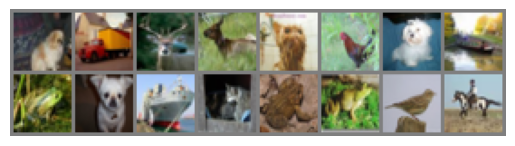

  dog truck  deer  deer   cat  bird   dog  ship  frog   dog  ship   cat  frog  frog  bird horse


In [5]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off') 
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:16]))
print(' '.join('%5s' % classes[labels[j]] for j in range(16)))

### Нейронная сеть

`ResNet-34` (https://arxiv.org/pdf/1512.03385v1)

In [6]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.downsample = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.downsample(x)
        out = self.relu(out)
        return out

class ResNet34(nn.Module):
    def __init__(self, block=BasicBlock, num_classes=10):
        super(ResNet34, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, self.in_planes, kernel_size=7,
                               stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_planes)
        self.relu = nn.ReLU(inplace=True)
        self.max_pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, 3, stride=1)
        self.layer2 = self._make_layer(block, 128, 4, stride=2)
        self.layer3 = self._make_layer(block, 256, 6, stride=2)
        self.layer4 = self._make_layer(block, 512, 3, stride=2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.linear = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.max_pool(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out
    
    def test(self, loader, loss_fn):
        correct = 0
        total = 0
        loss = 0.0
        device = next(self.parameters()).device
        with torch.no_grad():
            for images, labels in loader:
                images, labels = images.to(device), labels.to(device)
                outputs = self(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                loss += loss_fn(outputs, labels).item()
        loss /= len(loader)
        return correct, total, loss

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNet34().to(device)
print(summary(model, input_size=(BATCH_SIZE, 3, 32, 32)))

cross_entropy_loss = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=SCHEDULING_FACTOR, patience=SCHEDULING_PATIENCE, min_lr=LEARNING_RATE_MIN)

Layer (type:depth-idx)                   Output Shape              Param #
ResNet34                                 [256, 10]                 --
├─Conv2d: 1-1                            [256, 64, 16, 16]         9,408
├─BatchNorm2d: 1-2                       [256, 64, 16, 16]         128
├─ReLU: 1-3                              [256, 64, 16, 16]         --
├─MaxPool2d: 1-4                         [256, 64, 8, 8]           --
├─Sequential: 1-5                        [256, 64, 8, 8]           --
│    └─BasicBlock: 2-1                   [256, 64, 8, 8]           --
│    │    └─Conv2d: 3-1                  [256, 64, 8, 8]           36,864
│    │    └─BatchNorm2d: 3-2             [256, 64, 8, 8]           128
│    │    └─ReLU: 3-3                    [256, 64, 8, 8]           --
│    │    └─Conv2d: 3-4                  [256, 64, 8, 8]           36,864
│    │    └─BatchNorm2d: 3-5             [256, 64, 8, 8]           128
│    │    └─Sequential: 3-6              [256, 64, 8, 8]           --
│

In [8]:
best_accuracy = 0.0
training_error = []
total_start_time = time()

for epoch in range(NUM_EPOCHS):
    total_loss = 0.0
    correct = 0
    total = 0
    
    start_time = time()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = cross_entropy_loss(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    end_time = time()

    training_error.append(1 - correct / total)
    print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Elapsed {end_time - start_time:.2f} seconds, '
          f'Learning rate {scheduler.get_last_lr()[-1]:.4f}, ' 
          f'Loss: {total_loss/len(train_loader):.4f}, '
          f'Accuracy: {100 * correct / total:.2f}%')

    model.eval()
    test_correct, test_total, test_loss = model.test(test_loader, cross_entropy_loss)
    scheduler.step(test_loss)
    # scheduler.step()
    model.train()
    test_accuracy = 100 * test_correct / test_total
    print(f'Test Accuracy: {test_accuracy:.2f}%')

    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"Saved new best model with accuracy: {best_accuracy:.2f}%")

total_end_time = time()
print(f'Finished Training. Total training time: {total_end_time - total_start_time:.2f} seconds')

Epoch [1/100], Elapsed 16.90 seconds, Learning rate 0.1000, Loss: 2.6317, Accuracy: 17.94%
Test Accuracy: 23.02%
Saved new best model with accuracy: 23.02%
Epoch [2/100], Elapsed 16.49 seconds, Learning rate 0.1000, Loss: 1.8044, Accuracy: 29.00%
Test Accuracy: 31.96%
Saved new best model with accuracy: 31.96%
Epoch [3/100], Elapsed 14.63 seconds, Learning rate 0.1000, Loss: 1.5762, Accuracy: 39.80%
Test Accuracy: 40.59%
Saved new best model with accuracy: 40.59%
Epoch [4/100], Elapsed 14.14 seconds, Learning rate 0.1000, Loss: 1.3963, Accuracy: 48.19%
Test Accuracy: 48.89%
Saved new best model with accuracy: 48.89%
Epoch [5/100], Elapsed 14.54 seconds, Learning rate 0.1000, Loss: 1.2560, Accuracy: 54.35%
Test Accuracy: 54.64%
Saved new best model with accuracy: 54.64%
Epoch [6/100], Elapsed 14.68 seconds, Learning rate 0.1000, Loss: 1.1242, Accuracy: 59.52%
Test Accuracy: 57.69%
Saved new best model with accuracy: 57.69%
Epoch [7/100], Elapsed 14.40 seconds, Learning rate 0.1000, Loss

In [9]:
model.load_state_dict(torch.load('best_model.pth', weights_only=True))
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Test Accuracy: {100 * correct / total:.2f}%')

Test Accuracy: 74.11%


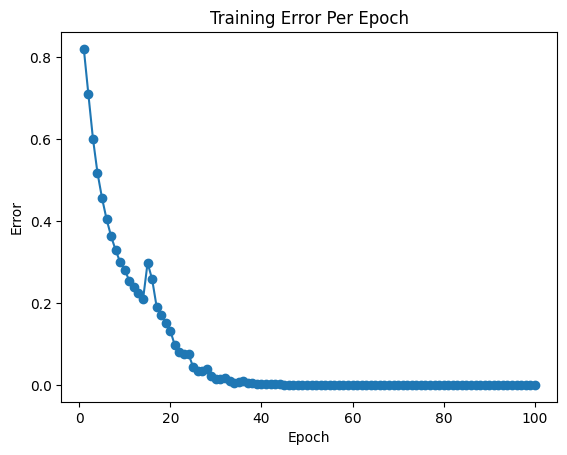

In [10]:
plt.plot(range(1, NUM_EPOCHS + 1), training_error, marker='o')
plt.title('Training Error Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.show()